<a href="https://colab.research.google.com/github/Parth-Rawri/CIFAR10/blob/main/CIFAR10_Image_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import tarfile
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

### Step 1: Download and Explore the Dataset

In [ ]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '/content/')

Using downloaded and verified file: /content/cifar10.tgz


In [ ]:
# Extract from archive
with tarfile.open('/content/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path = '/content/data/')

In [ ]:
data_dir = '/content/data/cifar10'

print(os.listdir(data_dir))

classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train']
['frog', 'ship', 'airplane', 'horse', 'bird', 'deer', 'automobile', 'cat', 'dog', 'truck']


Looking inside a couple of folders.

In [ ]:
airplane_files = os.listdir(data_dir + '/train/airplane')
print("No. of training examples for airplanes:", len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['2271.png', '3825.png', '3485.png', '1799.png', '4164.png']


In [ ]:
ship_test_files = os.listdir(data_dir + '/test/ship')
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0015.png', '0993.png', '0398.png', '0935.png', '0673.png']


Using the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(data_dir + '/train', transform = ToTensor())
test_dataset = ImageFolder(data_dir + '/test', transform = ToTensor())

In [ ]:
len(dataset), len(test_dataset)

(50000, 10000)

Looking at sample elements from the training dataset.

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [ ]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "(" + str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label:  airplane (0)


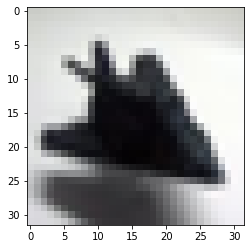

In [ ]:
img, label = dataset[0]
show_example(img, label)

Label:  airplane (0)


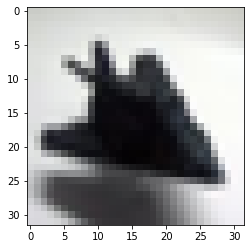

In [ ]:
show_example(*dataset[0])

Label:  airplane (0)


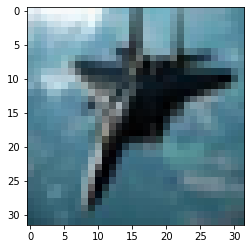

In [ ]:
show_example(*dataset[450])

### Step 2: Training and Validation Datasets

To ensure the selection of the same 5000 elements of the validation set, everytime the notebook is restarted, re run, etc. <br>
We are standardizing our validation set to evaluate our models. SO that we're not evaluating on a different set of images each time. <br>
This is done by setting a manual seed.




In [ ]:
random_seed = 34
torch.manual_seed(random_seed);

In [ ]:
val_percent = 0.1
val_size = int(len(dataset) * val_percent)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

Creating DataLoaders

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


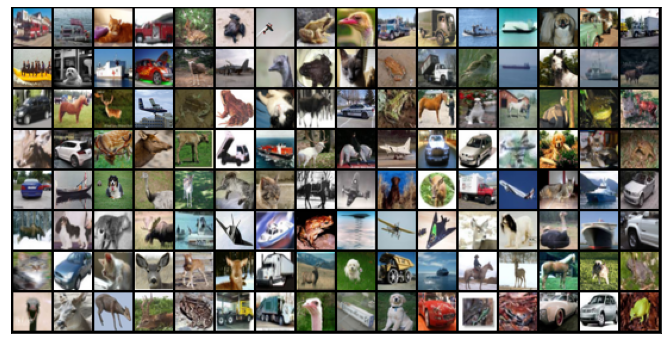

In [ ]:
show_batch(train_dl)

### Step 3: Developing the Model

Implementing a convolution operation on a 1 channel image with a 3x3 kernel.

In [ ]:
def apply_kernel(image, kernel):
    ri, ci = image.shape         # Image dimensions
    rk, ck = kernel.shape        # Kernel dimensions
    ro, co = ri-rk+1, ci-ck+1    # Output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i, j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
    return output

In [ ]:
sample_image = torch.tensor([
                             [3, 3, 2, 1, 0],
                             [0, 0, 1, 3, 1],
                             [3, 1, 2, 2, 3],
                             [2, 0, 0, 2, 2],
                             [2, 0, 0, 0, 1]], dtype = torch.float32)
sample_kernel = torch.tensor([
                              [0, 1, 2],
                              [2, 2, 0],
                              [0, 1, 2]], dtype = torch.float32)
apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

Developing a simple model!

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)

In [ ]:
pool = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = conv(images)
    print('out.shape', out.shape)
    out = pool(out)
    print('out.shape', out.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 32, 32])
out.shape torch.Size([128, 8, 32, 32])
out.shape torch.Size([128, 8, 16, 16])


In [ ]:
conv.weight.shape

torch.Size([8, 3, 3, 3])

We have 8 kernels (since we want 8 O/P channels); Each of these 8 kernels contains 3 matrices (since there are 3 I/P channels) of size 3x3

In [ ]:
# Displays 1st Kernel (1/8 Kernels)
conv.weight[0]

tensor([[[ 0.0578, -0.0031,  0.1010],
         [ 0.1776, -0.1686,  0.1019],
         [ 0.0673, -0.0786,  0.0537]],

        [[ 0.1367,  0.0755, -0.1831],
         [ 0.0629, -0.1649,  0.0577],
         [-0.0494,  0.1423, -0.1320]],

        [[ 0.1089, -0.0263,  0.1606],
         [-0.0221, -0.0231,  0.1773],
         [ 0.0624,  0.1403, -0.0645]]], grad_fn=<SelectBackward>)

In [ ]:
print(f"Matrix for Red:\n{conv.weight[0,0]}\nMatrix for Green:\n{conv.weight[0,1]}\nMatrix for Blue:\n{conv.weight[0,2]}")

Matrix for Red:
tensor([[ 0.0578, -0.0031,  0.1010],
        [ 0.1776, -0.1686,  0.1019],
        [ 0.0673, -0.0786,  0.0537]], grad_fn=<SelectBackward>)
Matrix for Green:
tensor([[ 0.1367,  0.0755, -0.1831],
        [ 0.0629, -0.1649,  0.0577],
        [-0.0494,  0.1423, -0.1320]], grad_fn=<SelectBackward>)
Matrix for Blue:
tensor([[ 0.1089, -0.0263,  0.1606],
        [-0.0221, -0.0231,  0.1773],
        [ 0.0624,  0.1403, -0.0645]], grad_fn=<SelectBackward>)


In [ ]:
# Displays all Kernels
conv.weight

Parameter containing:
tensor([[[[ 0.0578, -0.0031,  0.1010],
          [ 0.1776, -0.1686,  0.1019],
          [ 0.0673, -0.0786,  0.0537]],

         [[ 0.1367,  0.0755, -0.1831],
          [ 0.0629, -0.1649,  0.0577],
          [-0.0494,  0.1423, -0.1320]],

         [[ 0.1089, -0.0263,  0.1606],
          [-0.0221, -0.0231,  0.1773],
          [ 0.0624,  0.1403, -0.0645]]],


        [[[ 0.0499,  0.0549, -0.1848],
          [-0.1402,  0.1808,  0.0222],
          [-0.1870, -0.0993, -0.1370]],

         [[-0.1571, -0.1473, -0.0608],
          [ 0.1602,  0.0345, -0.1034],
          [-0.0298, -0.0012,  0.1915]],

         [[ 0.1036,  0.0994,  0.0503],
          [ 0.1719, -0.1492, -0.0109],
          [-0.0192,  0.0976, -0.0124]]],


        [[[ 0.0710, -0.0898, -0.0386],
          [-0.0482, -0.0943,  0.1798],
          [-0.1055,  0.1162,  0.0603]],

         [[ 0.0796, -0.1612, -0.0255],
          [ 0.1599, -0.0208,  0.1854],
          [ 0.0863, -0.1523, -0.1867]],

         [[-0.0427, -0

Max Pooling layer doesn't have any weights and biases. It doesn't have parameters, it just applies a rule.

In [ ]:
simple_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=2, stride=None, padding=0)
)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape', out.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 32, 32])
out.shape torch.Size([128, 8, 16, 16])


Image Classification Base Class - developed by extending the nn.Module class

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Extending the Imagine Classification Base Class to develop our problem specific model (the CIFAR10 CNN Model)

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # input: 3 x 32 x 32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            # output: 32 x 32 x 32
            nn.ReLU(),
            # output: 32 x 32 x 32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # output: 64 x 32 x 32
            nn.ReLU(),
            # output: 64 x 32 x 32
            nn.MaxPool2d(kernel_size=2, stride=None, padding=0),
            # output: 64 x 16 x 16
        
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=None, padding=0),
            # output: 128 x 8 x 8

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=None, padding=0),
            # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(in_features= 256*4*4, out_features= 1024),
            nn.ReLU(),
            nn.Linear(in_features= 1024, out_features= 512),
            nn.ReLU(),
            nn.Linear(in_features= 512, out_features= 10)
        )
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape', out.shape)
    print('out[0]:', out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 32, 32])
out.shape torch.Size([128, 10])
out[0]: tensor([ 0.0037, -0.0124, -0.0070,  0.0015, -0.0396,  0.0408, -0.0507, -0.0384,
        -0.0291,  0.0304], grad_fn=<SelectBackward>)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl =DeviceDataLoader(val_dl, device)
to_device(model, device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

### Step 4: Training the Model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

5851338

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.10074678808450699, 'val_loss': 2.3028061389923096}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.8063, val_loss: 1.4686, val_acc: 0.4534
Epoch [1], train_loss: 1.2425, val_loss: 1.0646, val_acc: 0.6202
Epoch [2], train_loss: 0.9550, val_loss: 0.9256, val_acc: 0.6746
Epoch [3], train_loss: 0.7748, val_loss: 0.8068, val_acc: 0.7187
Epoch [4], train_loss: 0.6261, val_loss: 0.7343, val_acc: 0.7411
Epoch [5], train_loss: 0.5052, val_loss: 0.7643, val_acc: 0.7462
Epoch [6], train_loss: 0.3967, val_loss: 0.7726, val_acc: 0.7514
Epoch [7], train_loss: 0.2990, val_loss: 0.8235, val_acc: 0.7643
Epoch [8], train_loss: 0.2186, val_loss: 0.8441, val_acc: 0.7635
Epoch [9], train_loss: 0.1551, val_loss: 1.1764, val_acc: 0.7359
CPU times: user 52.3 s, sys: 27.9 s, total: 1min 20s
Wall time: 2min 28s


In [ ]:
history

[{'train_loss': 1.8063150644302368,
  'val_acc': 0.4534352421760559,
  'val_loss': 1.468613862991333},
 {'train_loss': 1.2424654960632324,
  'val_acc': 0.6202205419540405,
  'val_loss': 1.0646251440048218},
 {'train_loss': 0.9549945592880249,
  'val_acc': 0.6745519042015076,
  'val_loss': 0.925637423992157},
 {'train_loss': 0.7747851610183716,
  'val_acc': 0.7187269926071167,
  'val_loss': 0.8068296313285828},
 {'train_loss': 0.6261206865310669,
  'val_acc': 0.7410845756530762,
  'val_loss': 0.7342604994773865},
 {'train_loss': 0.5052264332771301,
  'val_acc': 0.7462201118469238,
  'val_loss': 0.764336347579956},
 {'train_loss': 0.3967219293117523,
  'val_acc': 0.7513672113418579,
  'val_loss': 0.772572934627533},
 {'train_loss': 0.29902657866477966,
  'val_acc': 0.764292299747467,
  'val_loss': 0.8235042691230774},
 {'train_loss': 0.21856530010700226,
  'val_acc': 0.7634536027908325,
  'val_loss': 0.8441349864006042},
 {'train_loss': 0.15510980784893036,
  'val_acc': 0.735914528369903

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

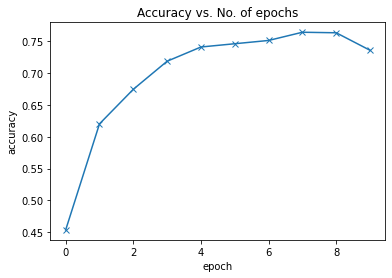

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

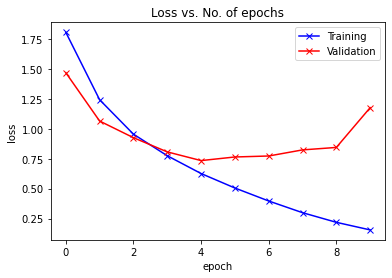

In [ ]:
plot_losses(history)

### Step 5: Testing on individual images

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


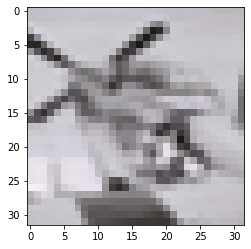

In [ ]:
img, label = test_dataset[450]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


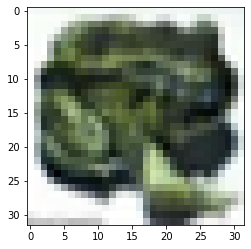

In [ ]:
img, label = test_dataset[6430]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane


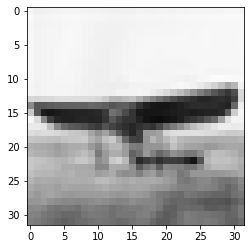

In [ ]:
img, label = test_dataset[644]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.7440429925918579, 'val_loss': 1.1569337844848633}

### Step 6: Saving the trained Model

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model. To load the model weights, we can redefine the model with the same structure, and use the `.load_state_dict` method.

In [ ]:
model2 = to_device(Cifar10CnnModel(), device)

In [ ]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [ ]:
evaluate(model2, test_loader)

{'val_acc': 0.7440429925918579, 'val_loss': 1.1569337844848633}